# Predicting COVID-19 Cases

## Problem Statement and Data Source

#### Data Source: Johns Hopkins Whiting School of Engineering
Data is publicly available on GitHub via: https://github.com/CSSEGISandData/COVID-19
All worldwide data was collected through this repo.

#### Problem Statement:
Can Supervised ML models accurately predict COVID-19 cases? And if so, can they predict relatively as well as time series models, such as ARIMA?

This is the question I hope to give an answer to in this project. Throughout the project, I hope to show how various techniques can algin ML models to perform well with time series data. The challenge, is the natural ordering in time series data. Many ML models assume no natural ordering of the target variable, however, time series data is necessarily ordered via time as models would be unable to accurately predict future values off randomly shuffled timedstamped observations.

# Imports and Modeling Prep

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import datetime
import random
import math
import time

from category_encoders import LeaveOneOutEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
)
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import (
    r2_score,
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error,
)

from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

## ARIMA Imports need to be done seperately further down to avoid
## python confusing the names of various functions

import warnings

warnings.filterwarnings("ignore")


from itertools import product
from pylab import rcParams

plt.style.use("ggplot")
rcParams["figure.figsize"] = 12, 6  ## setting as default value

%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Loading in Data From JHU Repo
confirmed_df = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
deaths_df = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
recoveries_df = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
latest_data = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/12-27-2020.csv"
)  ### shows what data has most recently been updated
us_medical_data = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/12-27-2020.csv"
)

<IPython.core.display.Javascript object>

In [3]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974


<IPython.core.display.Javascript object>

In [4]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,2179,2181,2191,2191,2191,2191,2237,2244,2244,2253
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,1170,1174,1181,1181,1190,1193,1199,1210,1217,1223
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,2745,2751,2756,2762,2769,2772,2777,2782,2786,2792
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,84,84,84,84,84,84,84,84,84,84
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,403,405,405,405,407,408,408,410,413,413


<IPython.core.display.Javascript object>

In [5]:
recoveries_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,41543,41612,41727,41727,41727,41727,42530,42666,42666,43291
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,32700,33185,33634,33634,34353,34648,34996,35551,36102,36535
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,66550,66855,67127,67395,67611,67808,67999,68185,68383,68589
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7360,7384,7432,7463,7463,7517,7548,7585,7615,7615
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,10627,10859,11044,11146,11189,11223,11266,11376,11477,11955


<IPython.core.display.Javascript object>

In [6]:
# latest_data.head() Most recent data updates!

<IPython.core.display.Javascript object>

In [7]:
# Removing These as not all countries have values for these
# Also we are not measuring these specific areas here
confirmed = confirmed_df.drop(
    columns=["Province/State", "Country/Region", "Lat", "Long"]
)
deaths = deaths_df.drop(columns=["Province/State", "Country/Region", "Lat", "Long"])
recoveries = recoveries_df.drop(
    columns=["Province/State", "Country/Region", "Lat", "Long"]
)

<IPython.core.display.Javascript object>

In [8]:
confirmed  ### Just getting the dates here for confirmed COVID cases

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21
0,0,0,0,0,0,0,0,0,0,0,...,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207
1,0,0,0,0,0,0,0,0,0,0,...,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705
2,0,0,0,0,0,0,0,0,0,0,...,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382
3,0,0,0,0,0,0,0,0,0,0,...,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348
4,0,0,0,0,0,0,0,0,0,0,...,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,0,2,2,2,2,2,2,2,2,2,...,1454,1456,1465,1474,1482,1494,1497,1504,1505,1509
268,0,0,0,0,0,0,0,0,0,0,...,135459,136736,138004,139223,140287,141219,142228,143169,144257,145252
269,0,0,0,0,0,0,0,0,0,0,...,2096,2097,2099,2101,2101,2101,2101,2101,2102,2104
270,0,0,0,0,0,0,0,0,0,0,...,20177,20462,20725,20997,21230,21582,21993,22645,23495,24297


<IPython.core.display.Javascript object>

In [9]:
dates = confirmed.keys()
world_cases = []
total_deaths = []
mortality_rate = []
recovery_rate = []
total_recovered = []
total_active = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()

    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum - death_sum - recovered_sum)

    # calculate rates
    mortality_rate.append(death_sum / confirmed_sum)
    recovery_rate.append(recovered_sum / confirmed_sum)

<IPython.core.display.Javascript object>

In [10]:
def daily_inc(data):
    """ To Display Increases in COVID Case Numbers"""
    d = []
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i] - data[i - 1])
    return d


def moving_avg(data, window_size):
    """ Creates Moving Average for Visualizing Case Numbers"""
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i : i + window_size]))
        else:
            moving_average.append(np.mean(data[i : len(data)]))
    return moving_average


# window size
window = 7

# confirmed cases
world_daily_increase = daily_inc(world_cases)
world_confirmed_avg = moving_avg(world_cases, window)
world_daily_increase_avg = moving_avg(world_daily_increase, window)

# deaths
world_daily_death = daily_inc(total_deaths)
world_death_avg = moving_avg(total_deaths, window)
world_daily_death_avg = moving_avg(world_daily_death, window)


# recoveries
world_daily_recovery = daily_inc(total_recovered)
world_recovery_avg = moving_avg(total_recovered, window)
world_daily_recovery_avg = moving_avg(world_daily_recovery, window)


# active
world_active_avg = moving_avg(total_active, window)

<IPython.core.display.Javascript object>

In [11]:
days_since_start = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates) + days_in_future)]).reshape(
    -1, 1
)
adjusted_dates = future_forecast[:-10]

<IPython.core.display.Javascript object>

In [12]:
### Setting Graphs to first day of observed data!
start = "1/22/2020"
start_date = datetime.datetime.strptime(start, "%m/%d/%Y")
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append(
        (start_date + datetime.timedelta(days=i)).strftime("%m/%d/%Y")
    )

<IPython.core.display.Javascript object>

# COVID Data EDA

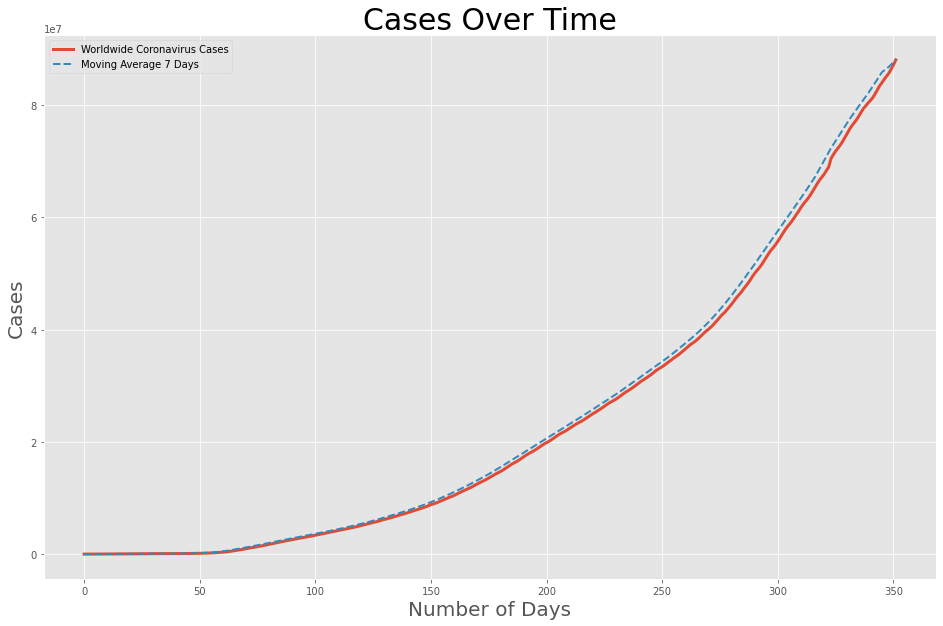

<IPython.core.display.Javascript object>

In [13]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, world_cases, linewidth=3)
plt.plot(adjusted_dates, world_confirmed_avg, linestyle="dashed", linewidth=2)
plt.title("Cases Over Time", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases", size=20)
plt.legend(["Worldwide Coronavirus Cases", "Moving Average 7 Days"])

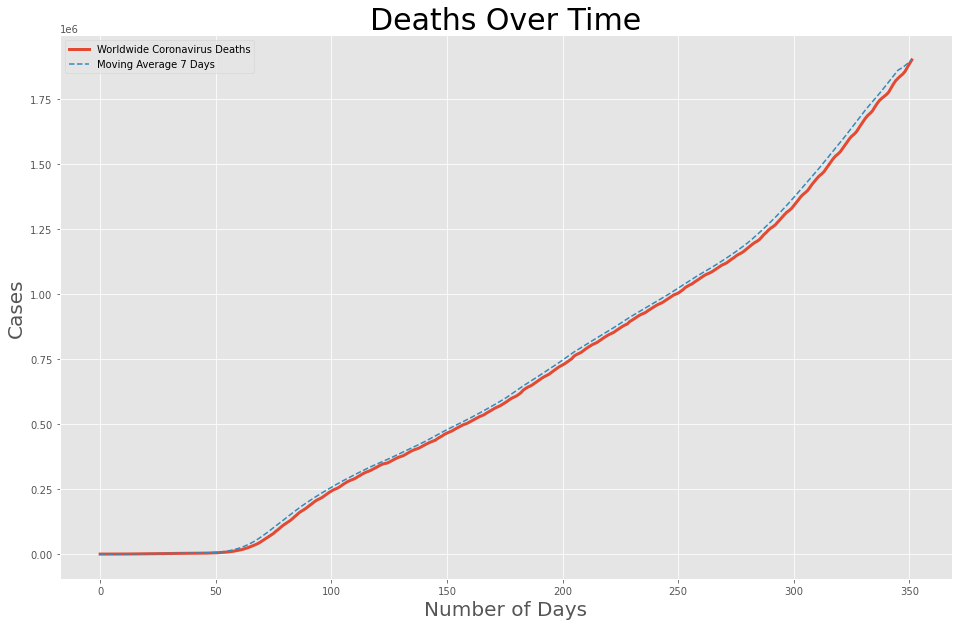

<IPython.core.display.Javascript object>

In [14]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths, linewidth=3)
plt.plot(adjusted_dates, world_death_avg, linestyle="dashed")
plt.title("Deaths Over Time", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases", size=20)
plt.legend(["Worldwide Coronavirus Deaths", "Moving Average 7 Days"])

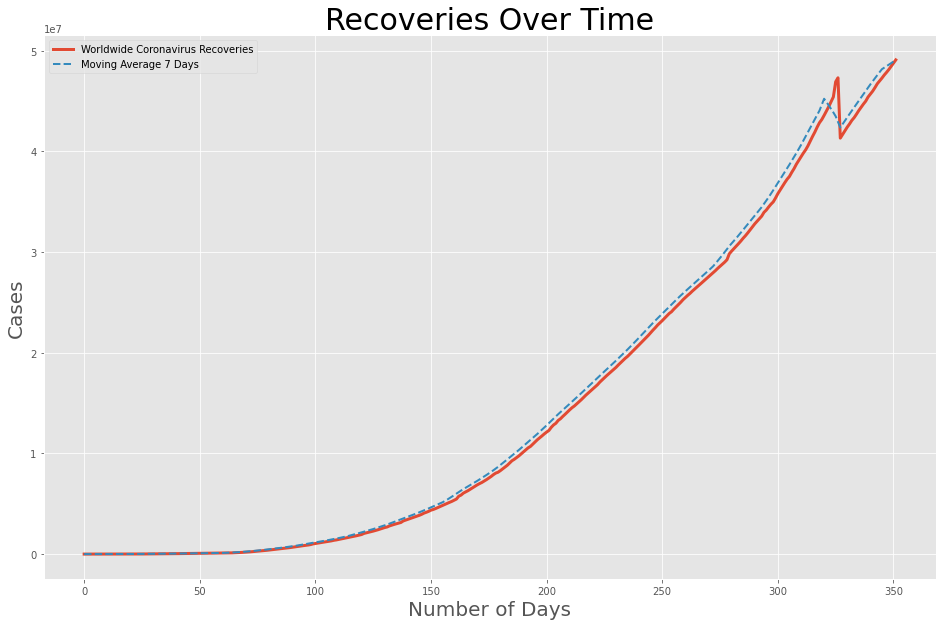

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_recovered, linewidth=3)
plt.plot(adjusted_dates, world_recovery_avg, linestyle="dashed", linewidth=2)
plt.title("Recoveries Over Time", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases", size=20)
plt.legend(["Worldwide Coronavirus Recoveries", "Moving Average 7 Days"])

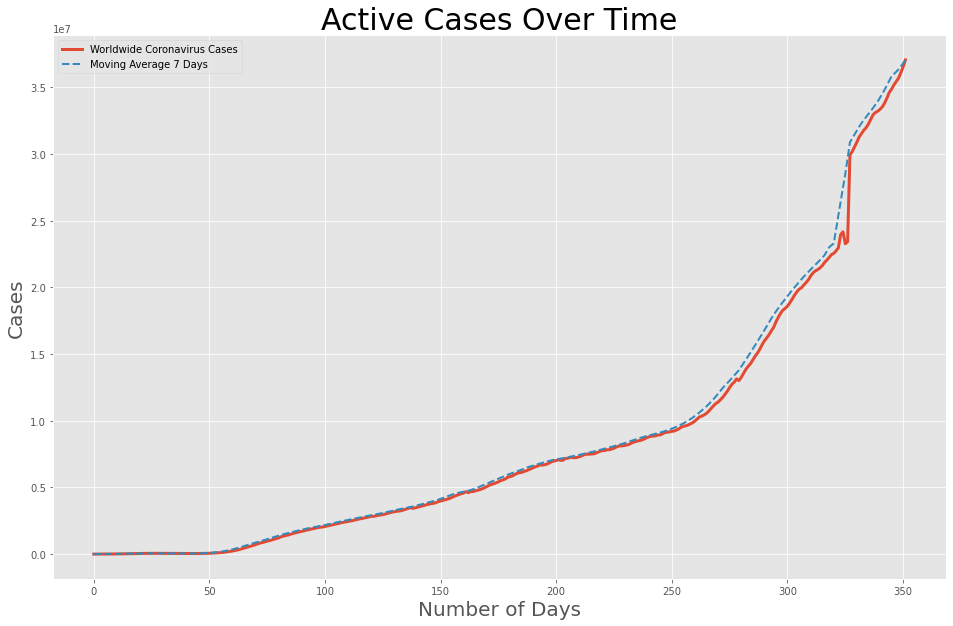

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_active, linewidth=3)
plt.plot(adjusted_dates, world_active_avg, linestyle="dashed", linewidth=2)
plt.title("Active Cases Over Time", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases", size=20)
plt.legend(["Worldwide Coronavirus Cases", "Moving Average 7 Days"])

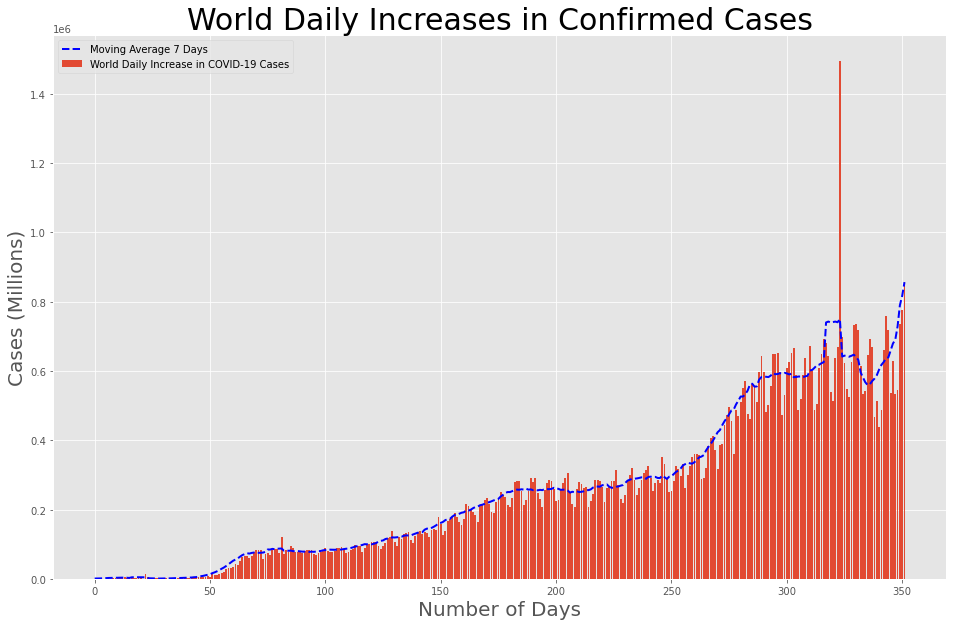

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_increase)
plt.plot(
    adjusted_dates,
    world_daily_increase_avg,
    color="blue",
    linestyle="dashed",
    linewidth=2,
)
plt.title("World Daily Increases in Confirmed Cases", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases (Millions)", size=20)
plt.legend(["Moving Average 7 Days", "World Daily Increase in COVID-19 Cases"])

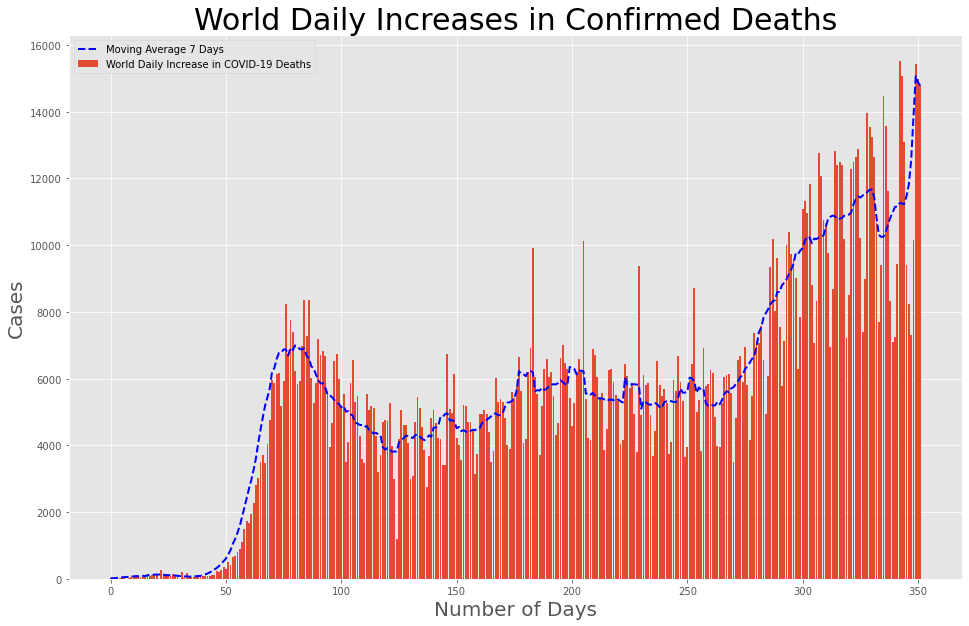

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_death)
plt.plot(
    adjusted_dates, world_daily_death_avg, color="blue", linestyle="dashed", linewidth=2
)
plt.title("World Daily Increases in Confirmed Deaths", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases", size=20)
plt.legend(
    [
        "Moving Average 7 Days",
        "World Daily Increase in COVID-19 Deaths",
    ]
)

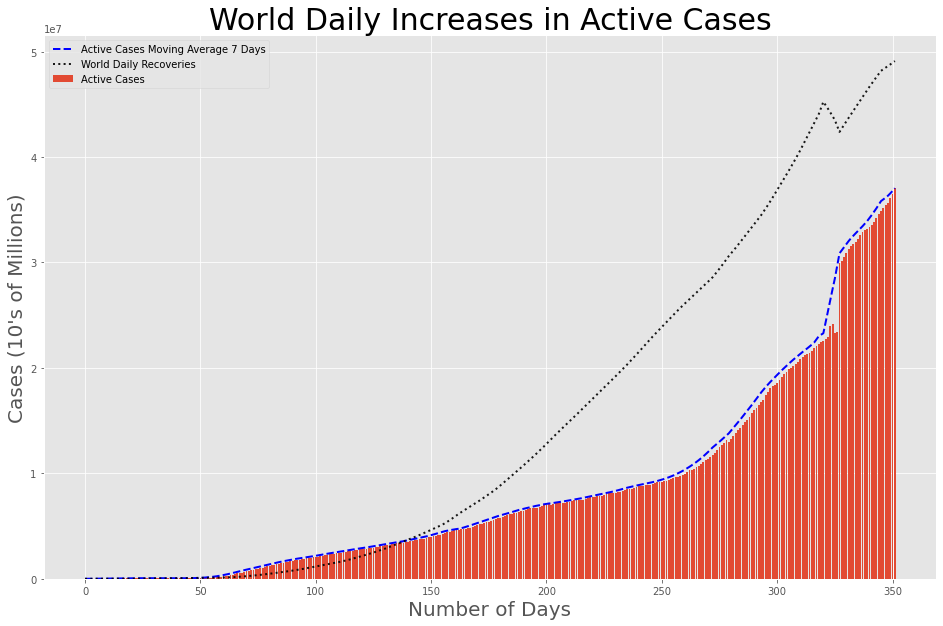

<IPython.core.display.Javascript object>

In [19]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, total_active)
plt.plot(
    adjusted_dates,
    world_active_avg,
    color="blue",
    linestyle="dashed",
    linewidth=2,
)
plt.plot(
    adjusted_dates,
    world_recovery_avg,
    color="black",
    linestyle=":",
    linewidth=2,
    alpha=0.9,
)
plt.title("World Daily Increases in Active Cases", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases (10's of Millions)", size=20)
plt.legend(
    [
        "Active Cases Moving Average 7 Days",
        "World Daily Recoveries",
        "Active Cases",
    ]
)

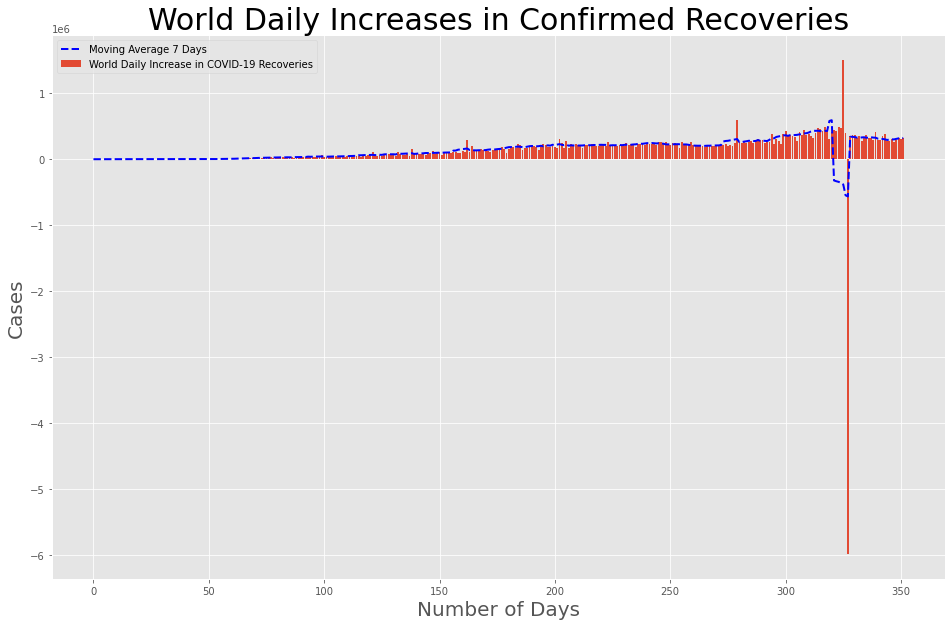

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(16, 10))
plt.bar(adjusted_dates, world_daily_recovery)
plt.plot(
    adjusted_dates,
    world_daily_recovery_avg,
    color="blue",
    linestyle="dashed",
    linewidth=2,
)
plt.title("World Daily Increases in Confirmed Recoveries", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases", size=20)
plt.legend(
    [
        "Moving Average 7 Days",
        "World Daily Increase in COVID-19 Recoveries",
    ],
)

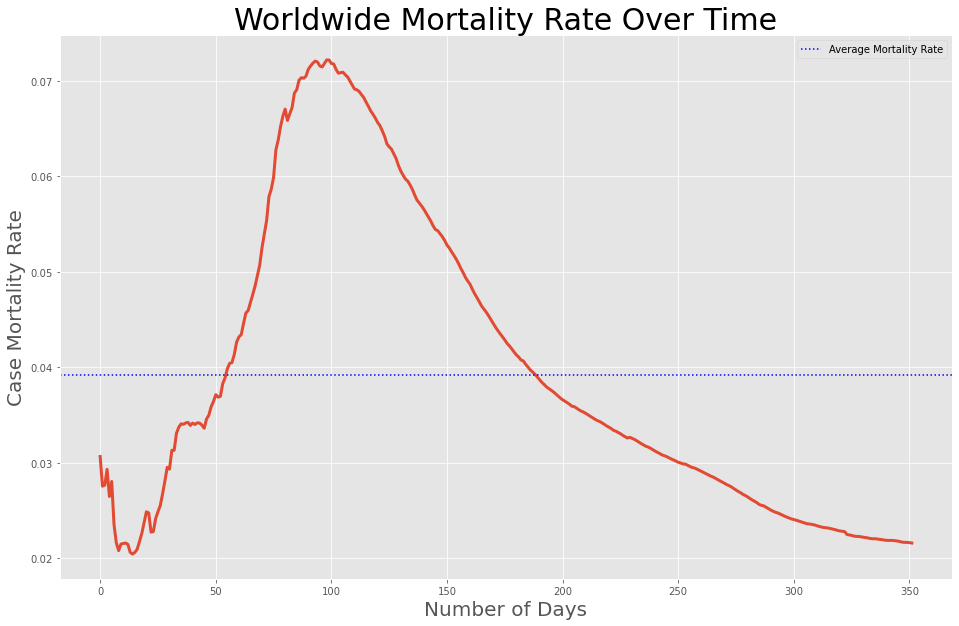

<IPython.core.display.Javascript object>

In [21]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, mortality_rate, linewidth=3)
plt.axhline(
    y=mean_mortality_rate, linestyle=":", color="blue", label="Average Mortality Rate"
)
plt.title("Worldwide Mortality Rate Over Time", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Case Mortality Rate", size=20)
plt.legend(loc="best")

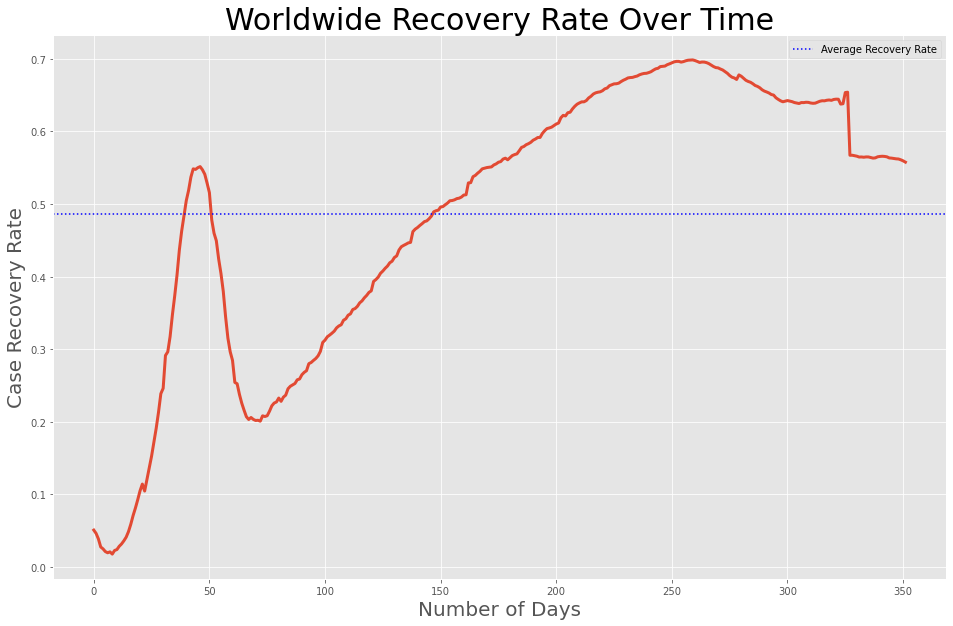

<IPython.core.display.Javascript object>

In [22]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, recovery_rate, linewidth=3)
plt.axhline(
    mean_recovery_rate, linestyle=":", color="blue", label="Average Recovery Rate"
)
plt.title("Worldwide Recovery Rate Over Time", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Case Recovery Rate", size=20)
plt.legend(loc="best")

Text(0, 0.5, 'Cases')

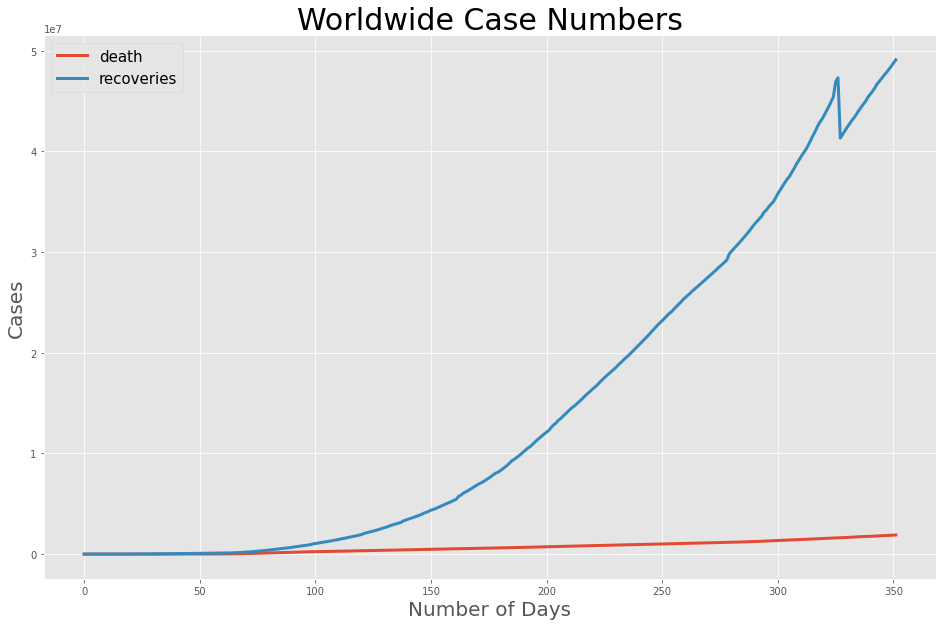

<IPython.core.display.Javascript object>

In [23]:
plt.figure(figsize=(16, 10))
plt.plot(adjusted_dates, total_deaths, linewidth=3)
plt.plot(adjusted_dates, total_recovered, linewidth=3)
plt.legend(["death", "recoveries"], loc="best", fontsize=15)
plt.title("Worldwide Case Numbers", size=30)
plt.xlabel("Number of Days", size=20)
plt.ylabel("Cases", size=20)

In [24]:
def get_country_info(country_name):
    country_cases = []
    country_deaths = []
    country_recoveries = []

    for i in dates:
        country_cases.append(
            confirmed_df[confirmed_df["Country/Region"] == country_name][i].sum()
        )
        country_deaths.append(
            deaths_df[deaths_df["Country/Region"] == country_name][i].sum()
        )
        country_recoveries.append(
            recoveries_df[recoveries_df["Country/Region"] == country_name][i].sum()
        )
    return (country_cases, country_deaths, country_recoveries)


def country_visualizations(country_name):
    country_info = get_country_info(country_name)
    country_cases = country_info[0]
    country_deaths = country_info[1]
    country_recoveries = country_info[2]

    country_daily_increase = daily_increase(country_cases)
    country_daily_death = daily_increase(country_deaths)
    country_daily_recovery = daily_increase(country_recoveries)

    country_plot(
        adjusted_dates,
        country_cases,
        country_daily_increase,
        country_daily_death,
        country_daily_recovery,
        country_name,
    )

<IPython.core.display.Javascript object>

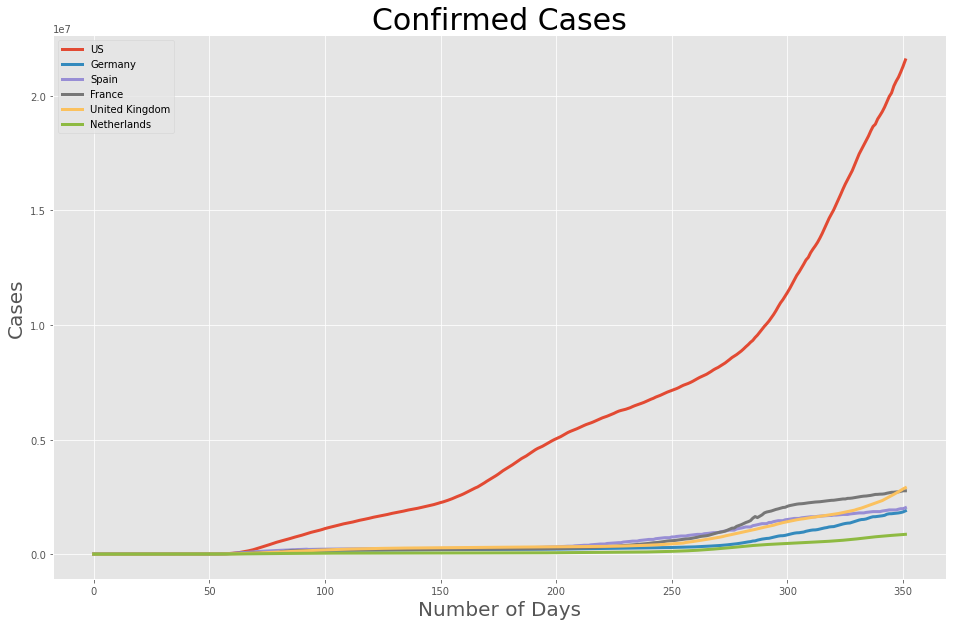

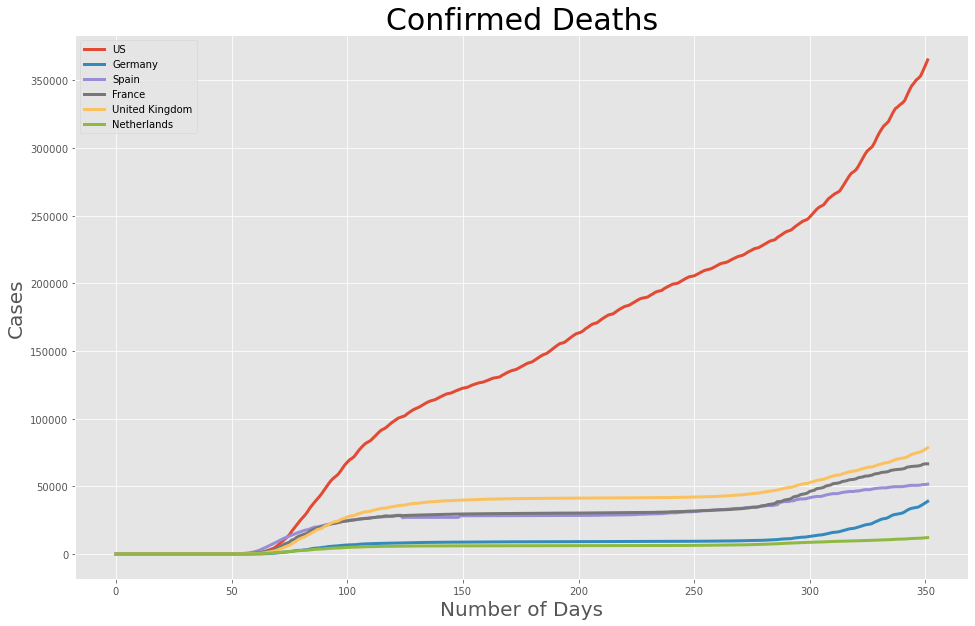

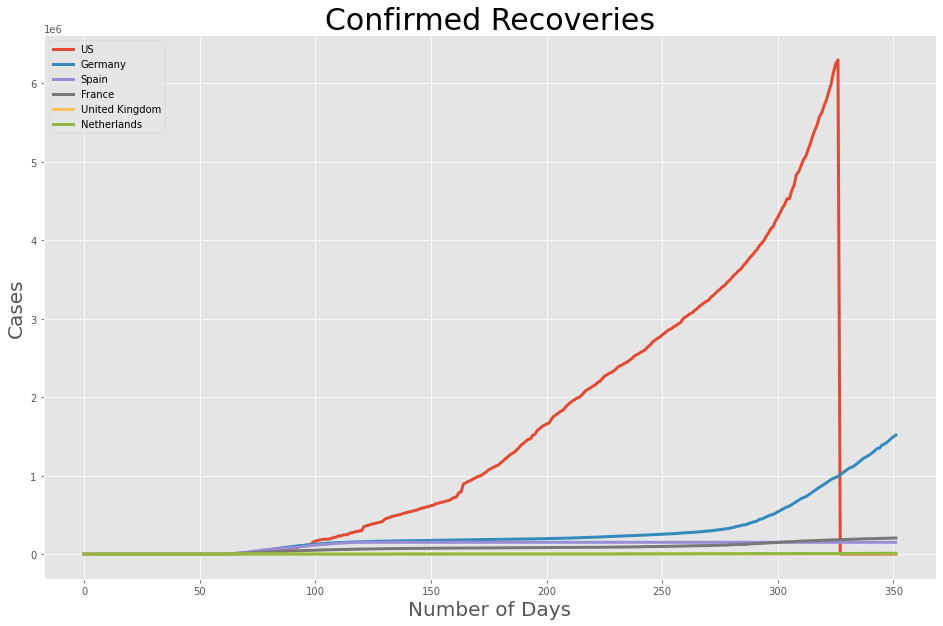

<IPython.core.display.Javascript object>

In [25]:
compare_countries = [
    "US",
    "Germany",
    "Spain",
    "France",
    "United Kingdom",
    "Netherlands"
    #     "Belgium"
    #     "Poland"
    #     "Czechia"
    #     "Switzerland"
    #     "Romania"
    #     "Sweden"
]


graph_name = [
    "Confirmed Cases",
    "Confirmed Deaths",
    "Confirmed Recoveries",
]
import matplotlib.cm as cm

for num in range(3):
    plt.figure(figsize=(16, 10))
    for country in compare_countries:
        plt.plot(get_country_info(country)[num], linewidth=3)
    plt.legend(compare_countries)
    plt.xlabel("Number of Days", size=20)
    plt.ylabel("Cases", size=20)
    plt.title(graph_name[num], size=30)

# Data Prep and Supervised ML Modeling

In [26]:
# Data Splitting For Analysis:
y = world_cases
X = days_since_start
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=False)

<IPython.core.display.Javascript object>

In [27]:
tscv = TimeSeriesSplit(n_splits=5, max_train_size=273)

<IPython.core.display.Javascript object>

In [28]:
# XGB Predictions:
grid = {
    "model__subsample": [0.5, 0.75, 1.0],
    "model__max_features": [0.5, 0.75, 1.0],
    "model__colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    "model__max_depth": [4, 6, 8, 10],
}

n_trees = 100
learning_rate = 2 / n_trees

# fmt: off
pipeline = Pipeline([
    ("model", XGBRegressor(n_estimators=n_trees, 
                                      learning_rate=learning_rate))
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, cv=tscv, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

xgb = pipeline_cv.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 643 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    9.9s finished


[19:29:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<IPython.core.display.Javascript object>

MAE: 20103624.25
MSE: 406372212397596.5


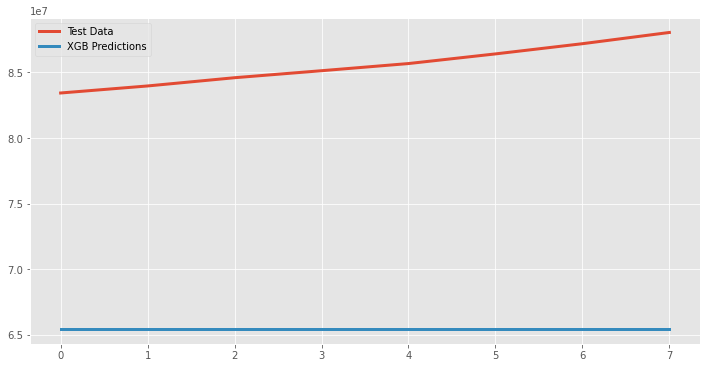

<IPython.core.display.Javascript object>

In [29]:
# xgb_pred = xgb.predict(future_forecast)
xgb_test_pred = xgb.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, linewidth=3)
plt.plot(xgb_test_pred, linewidth=3)
plt.legend(["Test Data", "XGB Predictions"])
print("MAE:", mean_absolute_error(xgb_test_pred, y_test))
print("MSE:", mean_squared_error(xgb_test_pred, y_test))

xgb_score = (mean_absolute_error(xgb_test_pred, y_test)), (
    r2_score(xgb_test_pred, y_test)
)

In [30]:
# Random Forest Predictions:
grid = {
    "model__max_depth": [i for i in range(2, 8)],
    "model__max_features": ["auto"],
    "model__n_estimators": [10, 50, 100, 200, 250],
    "model__min_samples_leaf": [1, 5, 10, 15, 20, 25, 30],
}

# fmt: off
pipeline = Pipeline([
    ("model", RandomForestRegressor())
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, cv=tscv, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

rf = pipeline_cv.best_estimator_

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:   39.1s finished


<IPython.core.display.Javascript object>

MAE: 3353066.9299999923
MSE: 13459562249468.01


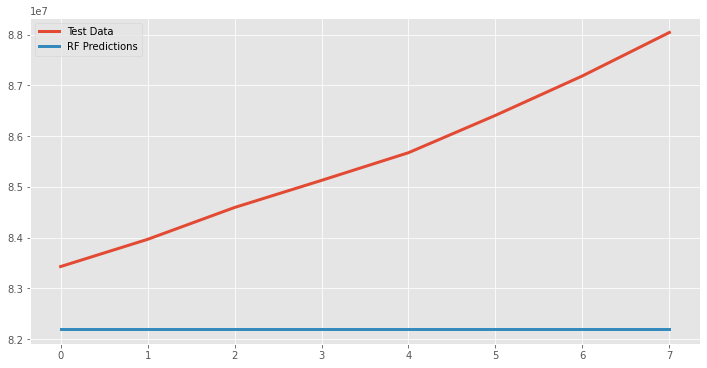

<IPython.core.display.Javascript object>

In [31]:
# rf_pred = rf.predict(future_forecast)
rf_test_pred = rf.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, linewidth=3)
plt.plot(rf_test_pred, linewidth=3)
plt.legend(["Test Data", "RF Predictions"])
print("MAE:", mean_absolute_error(rf_test_pred, y_test))
print("MSE:", mean_squared_error(rf_test_pred, y_test))

rf_score = (mean_absolute_error(rf_test_pred, y_test)), (r2_score(rf_test_pred, y_test))

In [32]:
# KNN Predictions:
grid = {
    "model__n_neighbors": [i for i in range(1, 10)],
    "model__weights": ["distance", "uniform"],
}


# fmt: off
pipeline = Pipeline([
    ("model", KNeighborsRegressor())
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, cv=tscv, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

knn = pipeline_cv.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished


<IPython.core.display.Javascript object>

MAE: 2841239.25
MSE: 10289144888149.0


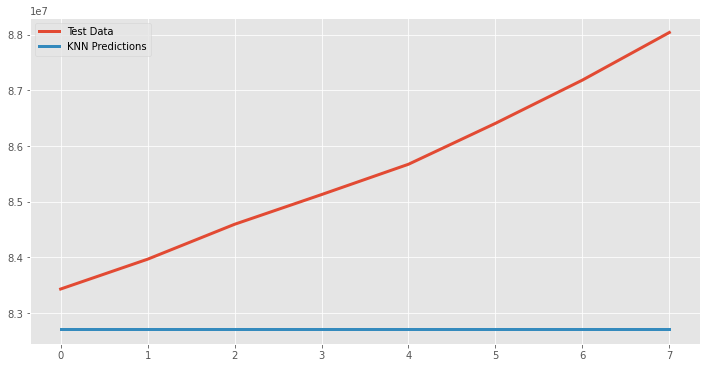

<IPython.core.display.Javascript object>

In [33]:
# knn_pred = knn.predict(future_forecast)
knn_test_pred = knn.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, linewidth=3)
plt.plot(knn_test_pred, linewidth=3)
plt.legend(["Test Data", "KNN Predictions"])
print("MAE:", mean_absolute_error(knn_test_pred, y_test))
print("MSE:", mean_squared_error(knn_test_pred, y_test))

knn_score = (mean_absolute_error(knn_test_pred, y_test)), (
    r2_score(knn_test_pred, y_test)
)

In [34]:
# SVM Predictions:
grid = {
    "model__kernel": ["linear", "poly", "rbf"],
    "model__degree": [i for i in range(1, 5)],
    #     "model__gamma": ['scale', 'auto'],
}


# fmt: off
pipeline = Pipeline([
    ("model", SVR(
    shrinking=True, kernel="poly", gamma=0.01, epsilon=1, degree=3, C=0.1))
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, cv=tscv, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

svr = pipeline_cv.best_estimator_

# svr = SVR(shrinking=True, kernel="poly", gamma=0.01, epsilon=1, degree=3, C=0.1)
svr.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished


Pipeline(memory=None,
         steps=[('model',
                 SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=1,
                     gamma=0.01, kernel='poly', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

<IPython.core.display.Javascript object>

MAE: 881587.2983269282
MSE: 831673823623.6965


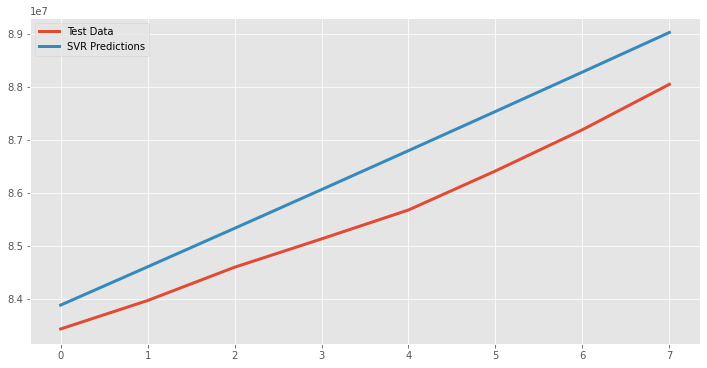

<IPython.core.display.Javascript object>

In [35]:
svr_test_pred = svr.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, linewidth=3)
plt.plot(svr_test_pred, linewidth=3)
plt.legend(["Test Data", "SVR Predictions"])
print("MAE:", mean_absolute_error(svr_test_pred, y_test))
print("MSE:", mean_squared_error(svr_test_pred, y_test))

svr_score = (mean_absolute_error(svr_test_pred, y_test)), (
    r2_score(svr_test_pred, y_test)
)

In [36]:
# Polynomial Regression:
poly = PolynomialFeatures(degree=4)
poly_X_train = poly.fit_transform(X_train)
poly_X_test = poly.fit_transform(X_test)
poly_forecast = poly.fit_transform(future_forecast)

bayesian_poly = PolynomialFeatures(degree=5)
bayes_poly_X_train = bayesian_poly.fit_transform(X_train)
bayes_poly_X_test = bayesian_poly.fit_transform(X_test)
bayes_future_forecast = bayesian_poly.fit_transform(future_forecast)

<IPython.core.display.Javascript object>

In [37]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train, y_train)
linear_pred = linear_model.predict(poly_X_test)
# linear_future_pred = linear_model.predict(poly_forecast)
print("MAE:", mean_absolute_error(linear_pred, y_test))
print("MSE:", mean_squared_error(linear_pred, y_test))

poly_score = (mean_absolute_error(linear_pred, y_test)), (r2_score(linear_pred, y_test))

MAE: 1945354.1051420718
MSE: 3942305628125.764


<IPython.core.display.Javascript object>

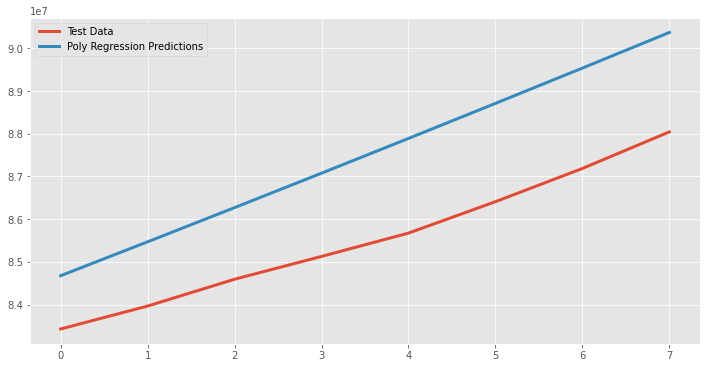

<IPython.core.display.Javascript object>

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, linewidth=3)
plt.plot(linear_pred, linewidth=3)
plt.legend(["Test Data", "Poly Regression Predictions"])

In [39]:
# Bayesian Ridge Polynomial Regression:

grid = {
    "model__tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    "model__alpha_1": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    "model__alpha_2": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    "model__lambda_1": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    "model__lambda_2": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
    "model__normalize": [True, False],
}

# bayesian_search = RandomSearchCV(
#     bayesian,
#     bayesian_grid,
#     scoring="neg_mean_squared_error",
#     cv=3,
#     return_train_score=True,
#     n_jobs=-1,
#     n_iter=40,
#     verbose=1,

# fmt: off
pipeline = Pipeline([
    ("model", BayesianRidge(fit_intercept=False))
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, cv=tscv, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

bayes = pipeline_cv.best_estimator_

bayes.fit(bayes_poly_X_train, y_train)

Fitting 5 folds for each of 6250 candidates, totalling 31250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 10536 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 21736 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 31250 out of 31250 | elapsed:   17.4s finished


Pipeline(memory=None,
         steps=[('model',
                 BayesianRidge(alpha_1=0.001, alpha_2=1e-07, alpha_init=None,
                               compute_score=False, copy_X=True,
                               fit_intercept=False, lambda_1=1e-07,
                               lambda_2=0.001, lambda_init=None, n_iter=300,
                               normalize=True, tol=1e-06, verbose=False))],
         verbose=False)

<IPython.core.display.Javascript object>

MAE: 2546027.821453918
MSE: 6729518257976.046


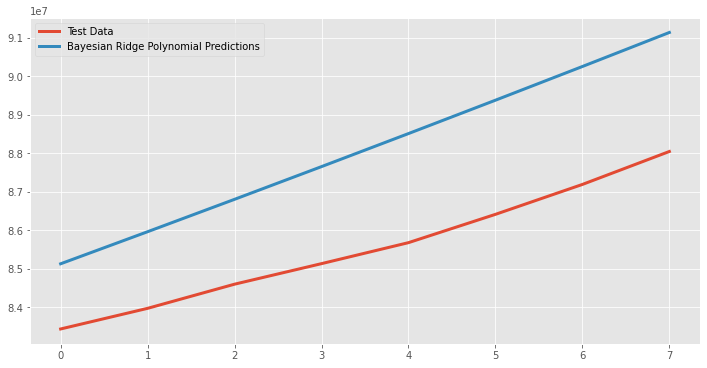

<IPython.core.display.Javascript object>

In [40]:
test_bayes_pred = bayes.predict(bayes_poly_X_test)
# bayes_pred = bayes.predict(bayes_future_forecast)
print("MAE:", mean_absolute_error(test_bayes_pred, y_test))
print("MSE:", mean_squared_error(test_bayes_pred, y_test))
plt.figure(figsize=(12, 6))
plt.plot(y_test, linewidth=3)
plt.plot(test_bayes_pred, linewidth=3)
plt.legend(["Test Data", "Bayesian Ridge Polynomial Predictions"])

bayes_score = (mean_absolute_error(test_bayes_pred, y_test)), (
    r2_score(test_bayes_pred, y_test)
)

## Model Predictions

In [41]:
svr_pred = svr.predict(future_forecast)
knn_pred = knn.predict(future_forecast)
linear_future_pred = linear_model.predict(poly_forecast)
bayes_pred = bayes.predict(bayes_future_forecast)
xgb_pred = xgb.predict(future_forecast)
rf_pred = rf.predict(future_forecast)

<IPython.core.display.Javascript object>

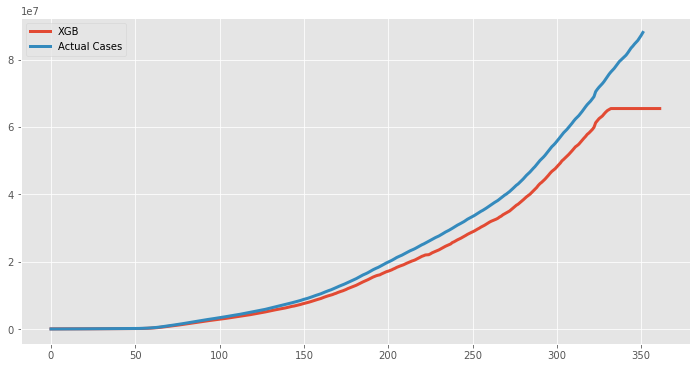

<IPython.core.display.Javascript object>

In [42]:
# XGBoost:
plt.figure(figsize=(12, 6))
plt.plot(xgb_pred, linewidth=3)
plt.plot(adjusted_dates, world_cases, linewidth=3)
plt.legend(["XGB", "Actual Cases"])

In [43]:
xgb_pred[-1]

65450620.0

<IPython.core.display.Javascript object>

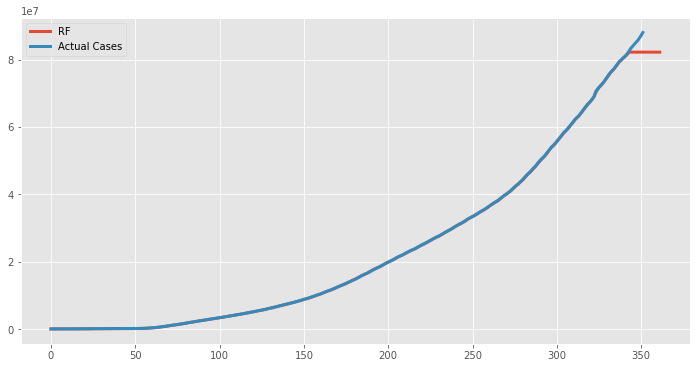

<IPython.core.display.Javascript object>

In [44]:
# RandomForest:
plt.figure(figsize=(12, 6))
plt.plot(rf_pred, linewidth=3)
plt.plot(adjusted_dates, world_cases, linewidth=3)
plt.legend(["RF", "Actual Cases"])

In [45]:
rf_pred[-1]

82201177.32000001

<IPython.core.display.Javascript object>

In [46]:
world_cases[-1], rf_pred[-10]  # seems like predictions have capped here

(array([88042762], dtype=int64), 82201177.32000001)

<IPython.core.display.Javascript object>

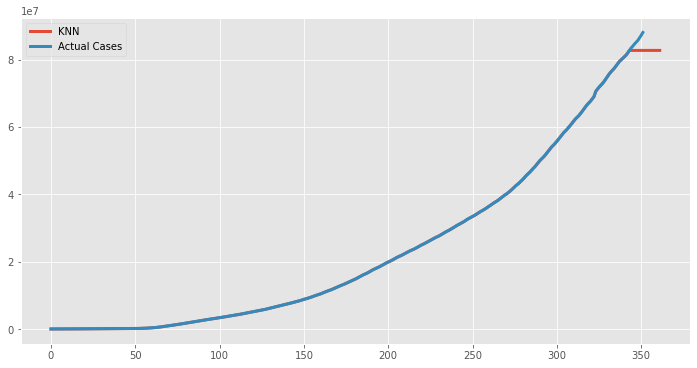

<IPython.core.display.Javascript object>

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(knn_pred, linewidth=3)
plt.plot(world_cases, linewidth=3)
plt.legend(["KNN", "Actual Cases"])

In [48]:
knn_pred[-1]

array([82713005.])

<IPython.core.display.Javascript object>

In [49]:
# Similarly here too, there's a plateu in predictions

<IPython.core.display.Javascript object>

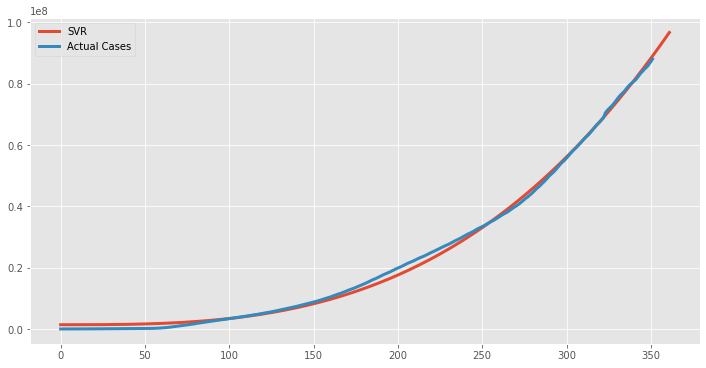

<IPython.core.display.Javascript object>

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(svr_pred, linewidth=3)
plt.plot(world_cases, linewidth=3)
plt.legend(["SVR", "Actual Cases"])

In [51]:
svr_pred[-11], world_cases[-1]

(89020209.0842051, array([88042762], dtype=int64))

<IPython.core.display.Javascript object>

In [52]:
svr_pred[-1]

96725692.21772785

<IPython.core.display.Javascript object>

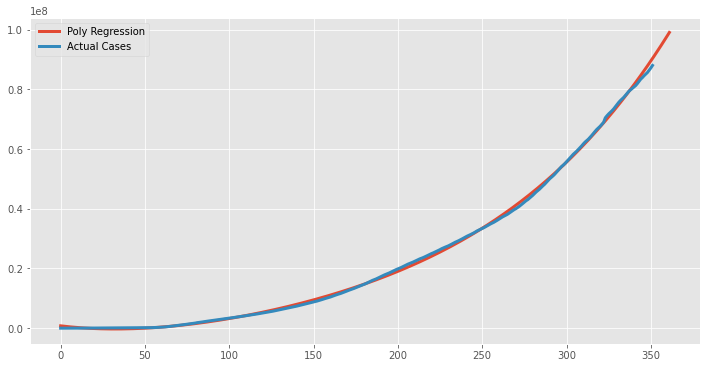

<IPython.core.display.Javascript object>

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(linear_future_pred, linewidth=3)
plt.plot(world_cases, linewidth=3)
plt.legend(["Poly Regression", "Actual Cases"])

In [54]:
linear_future_pred[-11] - world_cases[-1]

array([2326036.9052483])

<IPython.core.display.Javascript object>

In [55]:
linear_future_pred[-1]

array([99087216.44937307])

<IPython.core.display.Javascript object>

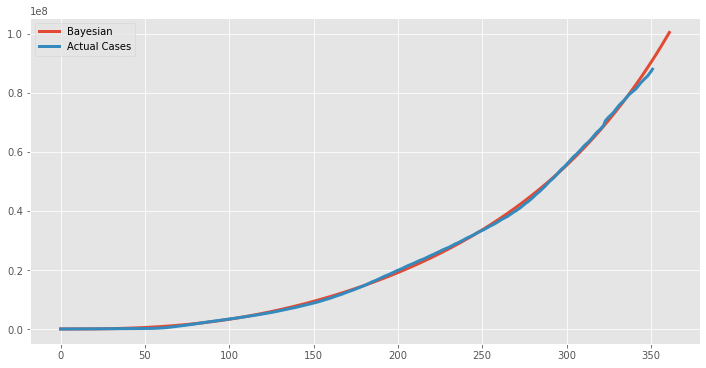

<IPython.core.display.Javascript object>

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(bayes_pred, linewidth=3)
plt.plot(world_cases, linewidth=3)
plt.legend(["Bayesian", "Actual Cases"])

In [57]:
bayes_pred[-11] - world_cases[-1]

array([3092653.87257987])

<IPython.core.display.Javascript object>

In [58]:
bayes_pred[-1]

100481935.58960614

<IPython.core.display.Javascript object>

In [59]:
rf_new_cases = rf_pred[-10:] - (world_cases)
rf_new_cases

array([[82200622.32000001, 82200622.32000001, 82200622.32000001, ...,
        82200622.32000001, 82200622.32000001, 82200622.32000001],
       [82200523.32000001, 82200523.32000001, 82200523.32000001, ...,
        82200523.32000001, 82200523.32000001, 82200523.32000001],
       [82200236.32000001, 82200236.32000001, 82200236.32000001, ...,
        82200236.32000001, 82200236.32000001, 82200236.32000001],
       ...,
       [-4208159.67999999, -4208159.67999999, -4208159.67999999, ...,
        -4208159.67999999, -4208159.67999999, -4208159.67999999],
       [-4985362.67999999, -4985362.67999999, -4985362.67999999, ...,
        -4985362.67999999, -4985362.67999999, -4985362.67999999],
       [-5841584.67999999, -5841584.67999999, -5841584.67999999, ...,
        -5841584.67999999, -5841584.67999999, -5841584.67999999]])

<IPython.core.display.Javascript object>

## ARIMA Time Series

In [60]:
import pmdarima as pmd
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

<IPython.core.display.Javascript object>

In [61]:
# printing out just the p-value for stationarity test
print(adfuller(world_cases)[1])

0.998950045465619


<IPython.core.display.Javascript object>

In [62]:
series = pd.DataFrame(world_cases, dates, columns=["total_cases"])

<IPython.core.display.Javascript object>

In [63]:
series

,total_cases
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
1/3/21,85128646
1/4/21,85673981
1/5/21,86409337
1/6/21,87186540


<IPython.core.display.Javascript object>

In [64]:
# Train test splitting for the same splits used in the ML models above
train, test = train_test_split(series, train_size=336)

<IPython.core.display.Javascript object>

In [65]:
# Defining and fitting pipeline
pipeline = Pipeline(
    [
        (
            "boxcox",
            BoxCoxEndogTransformer(lmbda2=1e-6),
        ),  # lmbda2 avoids negative values
        (
            "arima",
            pmd.AutoARIMA(
                seasonal=False, m=12, cv=tscv, suppress_warnings=True, trace=True
            ),
        ),
    ]
)

pipeline.fit(train)
arima = pipeline.get_params

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=460.947, Time=0.49 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=581.421, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=488.244, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=456.827, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=579.421, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=457.362, Time=0.15 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=457.431, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=459.311, Time=0.35 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=454.941, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=455.459, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=455.528, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=486.247, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=457.409, Time=0.18 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.881 seconds


<IPython.core.display.Javascript object>

In [66]:
print(pipeline.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  336
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -225.471
Date:                Fri, 08 Jan 2021   AIC                            454.941
Time:                        19:30:15   BIC                            462.564
Sample:                             0   HQIC                           457.981
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6473      0.018    -35.342      0.000      -0.683      -0.611
sigma2         0.2255      0.005     43.742      0.000       0.215       0.236
Ljung-Box (Q):                       93.38   Jarque-

<IPython.core.display.Javascript object>

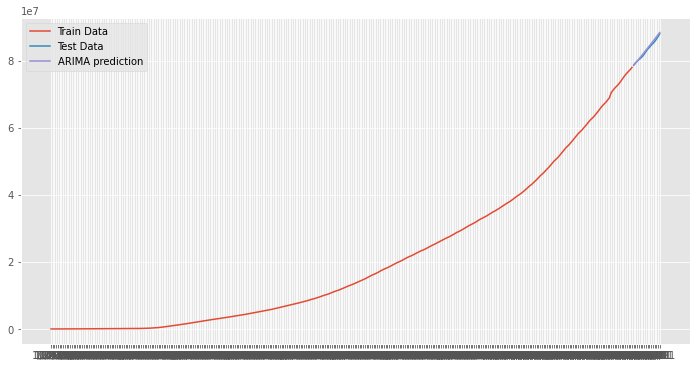

<IPython.core.display.Javascript object>

In [67]:
arima_pred = pd.DataFrame(pipeline.predict(n_periods=len(test)), index=test.index)
arima_pred.columns = ["predicted_cases"]
plt.figure(figsize=(12, 6))
ax = plt.plot(pd.DataFrame(train), label="Train Data")
ax1 = plt.plot(pd.DataFrame(test), label="Test Data")
# plt.plot(world_cases, label="Confirmed Cases")
ax2 = plt.plot(arima_pred, label="ARIMA prediction")
plt.legend(loc="best")

In [68]:
mean_absolute_error(arima_pred, test), r2_score(arima_pred, test)
## So our ARIMA Model explained roughly 93 percent of case variation
## The model could be off by roughly 259,556 cases for any
## given observed day!! --- IF we boxcox transform

(408905.19793910906, 0.9768106823468556)

<IPython.core.display.Javascript object>

In [69]:
arima_pred

,predicted_cases
12/23/20,7.864775e+07
12/24/20,7.927500e+07
12/25/20,7.990590e+07
12/26/20,8.054047e+07
12/27/20,8.117872e+07
12/28/20,8.182067e+07
12/29/20,8.246633e+07
12/30/20,8.311571e+07
12/31/20,8.376883e+07
1/1/21,8.442570e+07


<IPython.core.display.Javascript object>

## Comparing Model's Performance

In [70]:
mean_absolute_error(arima_pred, test)

408905.19793910906

<IPython.core.display.Javascript object>

In [71]:
# from sklearn.utils import check_arrays


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

<IPython.core.display.Javascript object>

In [72]:
# Score lists:
r2_scores = []
explained_var_scores = []
mae_scores = []
mape_scores = []

models = [
    #     arima_pred,
    svr_test_pred,
    knn_test_pred,
    linear_pred,
    test_bayes_pred,
    xgb_test_pred,
    rf_test_pred,
]

for model in models:
    r2_scores.append(r2_score(model, y_test))
    explained_var_scores.append(explained_variance_score(model, y_test))
    mae_scores.append(mean_absolute_error(model, y_test))
    mape_scores.append(mean_absolute_percentage_error(model, y_test))

<IPython.core.display.Javascript object>

In [73]:
print(r2_scores)

[0.70610291054502, 0.0, -0.13586413349909066, -0.7385257018714153, 0.0, 0.0]


<IPython.core.display.Javascript object>

In [74]:
print(explained_var_scores)

[0.9807486721584697, 0.0, 0.9545046961077731, 0.9361218923971355, 0.0, 0.0]


<IPython.core.display.Javascript object>

In [75]:
print(mae_scores)

[881587.2983269282, 2841239.25, 1945354.1051420718, 2546027.821453918, 20103624.25, 3353066.9299999923]


<IPython.core.display.Javascript object>

In [76]:
print(mape_scores)  # These are %'s

[2.2691556849989554, 3.4350574616410086, 2.215005525756207, 3.3012938578333983, 30.715712471478497, 4.0790984257401535]


<IPython.core.display.Javascript object>

In [77]:
r2_score(arima_pred, test), explained_variance_score(
    arima_pred, test
), mean_absolute_error(arima_pred, test), mean_absolute_percentage_error(
    arima_pred, test
)

(0.9768106823468556,
 0.9932762467687449,
 408905.19793910906,
 0.48319707582540833)

<IPython.core.display.Javascript object>

Based off the above scores for each model, the overall most accurate model here is the SVR model! It has the highest explained variance and R^2 scores, as well as having the lowest MAE score. On average, this model will be within 332,600 of the confirmed COVID cases (worldwide) for any given day.

### Results & Takeaway:

##### Best Supervised ML model: SVR
Our SVR model seemed to perform the best overall out of the other supervised models, with polynomial transforms providing the best accuracy in predicting case numbers.

##### Best Overall Model: ARIMA Time Series
This type of model is specifically designed for time series analysis, so it intiutively makes sense that this model would outperform the other ML models which have a harder time being adapted to time series data.

# Miscellaneous Code

In [78]:
models_to_stack = [bayes]

<IPython.core.display.Javascript object>

In [79]:
from vecstack import stacking

<IPython.core.display.Javascript object>

In [80]:
S_train, S_test = stacking(
    models_to_stack,
    X_train,
    y_train,
    X_test,
    regression=True,
    metric=r2_score,
    shuffle=False,
    random_state=42,
    verbose=1,
)

task:         [regression]
metric:       [r2_score]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [Pipeline]
    ----
    MEAN:     [-41.29459574] + [55.20420139]
    FULL:     [0.36685056]



<IPython.core.display.Javascript object>

In [81]:
# model = svr

# model = model.fit(S_train, y_train)
# y_pred = model.predict(S_test)
# print("Final prediction score: [%.8f]" % r2_score(y_test, y_pred))

<IPython.core.display.Javascript object>

In [82]:
### Okay so stacking models here did not help!

<IPython.core.display.Javascript object>

In [4]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [ ]:
st hello